# set up environment

versions that worked:

hssm 0.2.2
pymc 5.14
python 3.11

hssm 0.2.3
pymc newest 

In [3]:
# run on hssm_test
# Basics
import os
import sys
import time
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import numpy as np
import pandas as pd
import pathlib
import seaborn
from pathlib import Path 
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrix
from ssms.basic_simulators.simulator import simulator
import bambi as bmb
from pandas.api.types import CategoricalDtype
import ssms
import pytensor  # Graph-based tensor library
import hssm
# Set float type to float32 to avoid a current bug in PyMC 
# This will not be necessary in the future
hssm.set_floatX("float32")

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


# set up paths

In [4]:
basepath = '/users/afengler/data/proj_tt/oddballLearningMPIB'

# Check whether save directories exist; if not, create them
pathlib.Path(basepath+'/models/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/results/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/plots/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/ppc/hssm/').mkdir(parents=True, exist_ok=True)

# set up data

In [5]:
df = pd.read_csv(basepath+'/data/OB_singletrial_YAOA.csv')

df['response'] = df['accuracy']
# And then modify the 'response' column where the condition is met
df.loc[df['response'] == 0, 'response'] = -1

df.rename(columns={'reactiontime': 'rt'}, inplace=True)
df.rename(columns={'id': 'participant_id'}, inplace=True)

oddballDataDay2 = df[df['response'].notna()]

data=oddballDataDay2[:]
dataForModel = data[data['pupil'].notna()]

dataForModel = dataForModel.copy()
dataForModel = dataForModel[dataForModel['beta_insula'].notna()]

dataForModel = dataForModel.copy()
dataForModel = dataForModel[dataForModel['switch_condition_num'].notna()]


dataForModel['switch_condition_num']=isinstance(dataForModel['switch_condition_num'].dtype, CategoricalDtype)

### first look at real data RT

In [59]:
oddballDataDay2.rt.min()

0.0201793451615231

In [57]:
oddballDataDay2['rtPlot']=oddballDataDay2['rt']
oddballDataDay2.loc[oddballDataDay2['response'] == -1,'rtPlot']=oddballDataDay2.loc[oddballDataDay2['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions raw')
for i, subj_data in oddballDataDay2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-3,3)   
plt.savefig('real_subRT_dist_vanillaAllFreeParams.pdf')

/tmp/ipykernel_3891403/1451470133.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oddballDataDay2['rtPlot']=oddballDataDay2['rt']


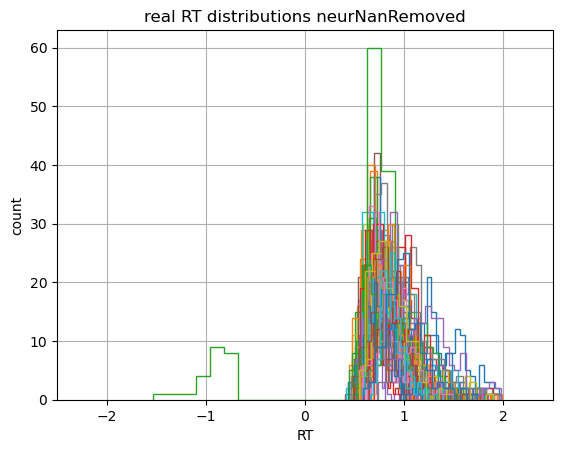

In [4]:
dataForModel['rtPlot']=dataForModel['rt']
dataForModel.loc[dataForModel['response'] == -1,'rtPlot']=dataForModel.loc[dataForModel['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions neurNanRemoved')
for i, subj_data in dataForModel.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-2.5,2.5)   
plt.savefig('real_subRT_dist_neurNanRemoved.pdf')

### day2SubList

In [10]:
# based on the real data, we figure:
# we need to simulate data with 'participant_id','rt',and 'response' 
# we need to get the correct sub numbers out and also correct trial number (samples in simulation) per subject
day2SubList=oddballDataDay2['participant_id'].unique()
len(day2SubList)


71

# simulate data: simplest DDM all params free

## nuts numpyro

In [8]:
ssms.config.model_config['ddm']

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'boundary_params': [],
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'nchoices': 2,
 'simulator': <cyfunction ddm_flexbound at 0x7f90a0f72260>}

In [82]:
vanillaHDDMallFree_simData=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2.loc[oddballDataDay2['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(2,0.05), 
                                      np.random.normal(1,0.05), 
                                      np.random.normal(0.6,0.05),
                                      np.random.normal(0.35,0.01)]

    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simData=pd.concat([vanillaHDDMallFree_simData, subDataset], ignore_index=True)

In [83]:
vanillaHDDMallFree_simData

participant_id        rt  response
0             42013.0  0.539640       1.0
1             42013.0  0.744280       1.0
2             42013.0  0.505983       1.0
3             42013.0  1.406529       1.0
4             42013.0  0.910031       1.0
...               ...       ...       ...
11222         62433.0  0.927285       1.0
11223         62433.0  0.593821       1.0
11224         62433.0  0.482578       1.0
11225         62433.0  0.547123       1.0
11226         62433.0  0.521996       1.0

[11227 rows x 3 columns]

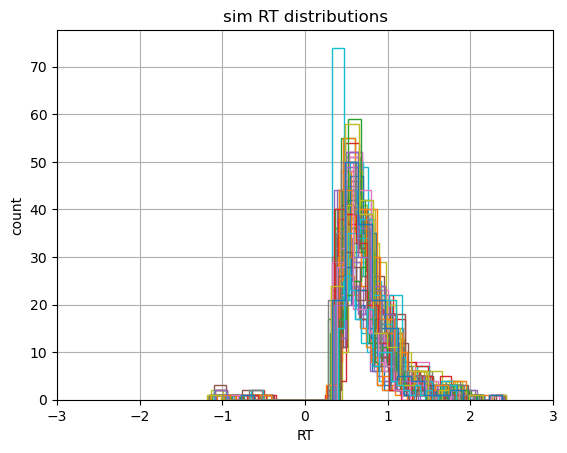

In [84]:
vanillaHDDMallFree_simData['rtPlot']=vanillaHDDMallFree_simData['rt']
vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']=vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions')
for i, subj_data in vanillaHDDMallFree_simData.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-3,3)   
plt.savefig('sim_subRT_dist.pdf')

In [85]:
ddm_simple_allFree_hier = hssm.HSSM(
    data=vanillaHDDMallFree_simData,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [81]:
ddm_simple_allFree_hier

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 11084

Parameters:

v:
    Formula: v ~ 1 + (1|participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 2.0, sigma: 3.0)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + (1|participant_id)
    Priors:
        a_Intercept ~ Gamma(mu: 1.5, sigma: 0.75)
        a_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Formula: z ~ 1 + (1|participant_id)
    Priors:
        z_Intercept ~ Beta(alpha: 10.0, beta: 10.0)
        z_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.0, 1.0)

t:
    Formula: t ~ 1 + (1|participant_id)
    Priors:
        t_Intercept ~ Gamma(mu: 

In [86]:
inferenceData_ddm_simple_allFree_hier=ddm_simple_allFree_hier.sample(
    sampler="nuts_numpyro",
    chains=2,
    draws=400,
    tune=400,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/minico

In [87]:
inferenceData_ddm_simple_allFree_hier

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

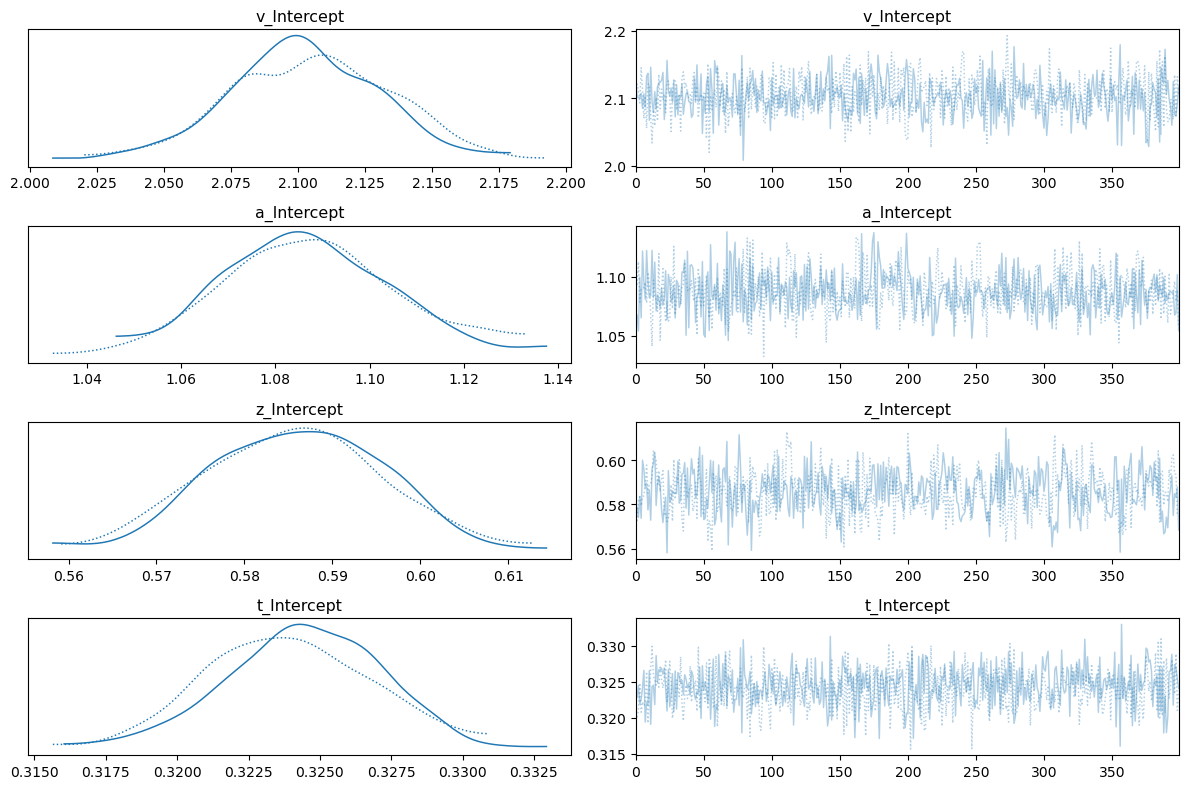

In [88]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

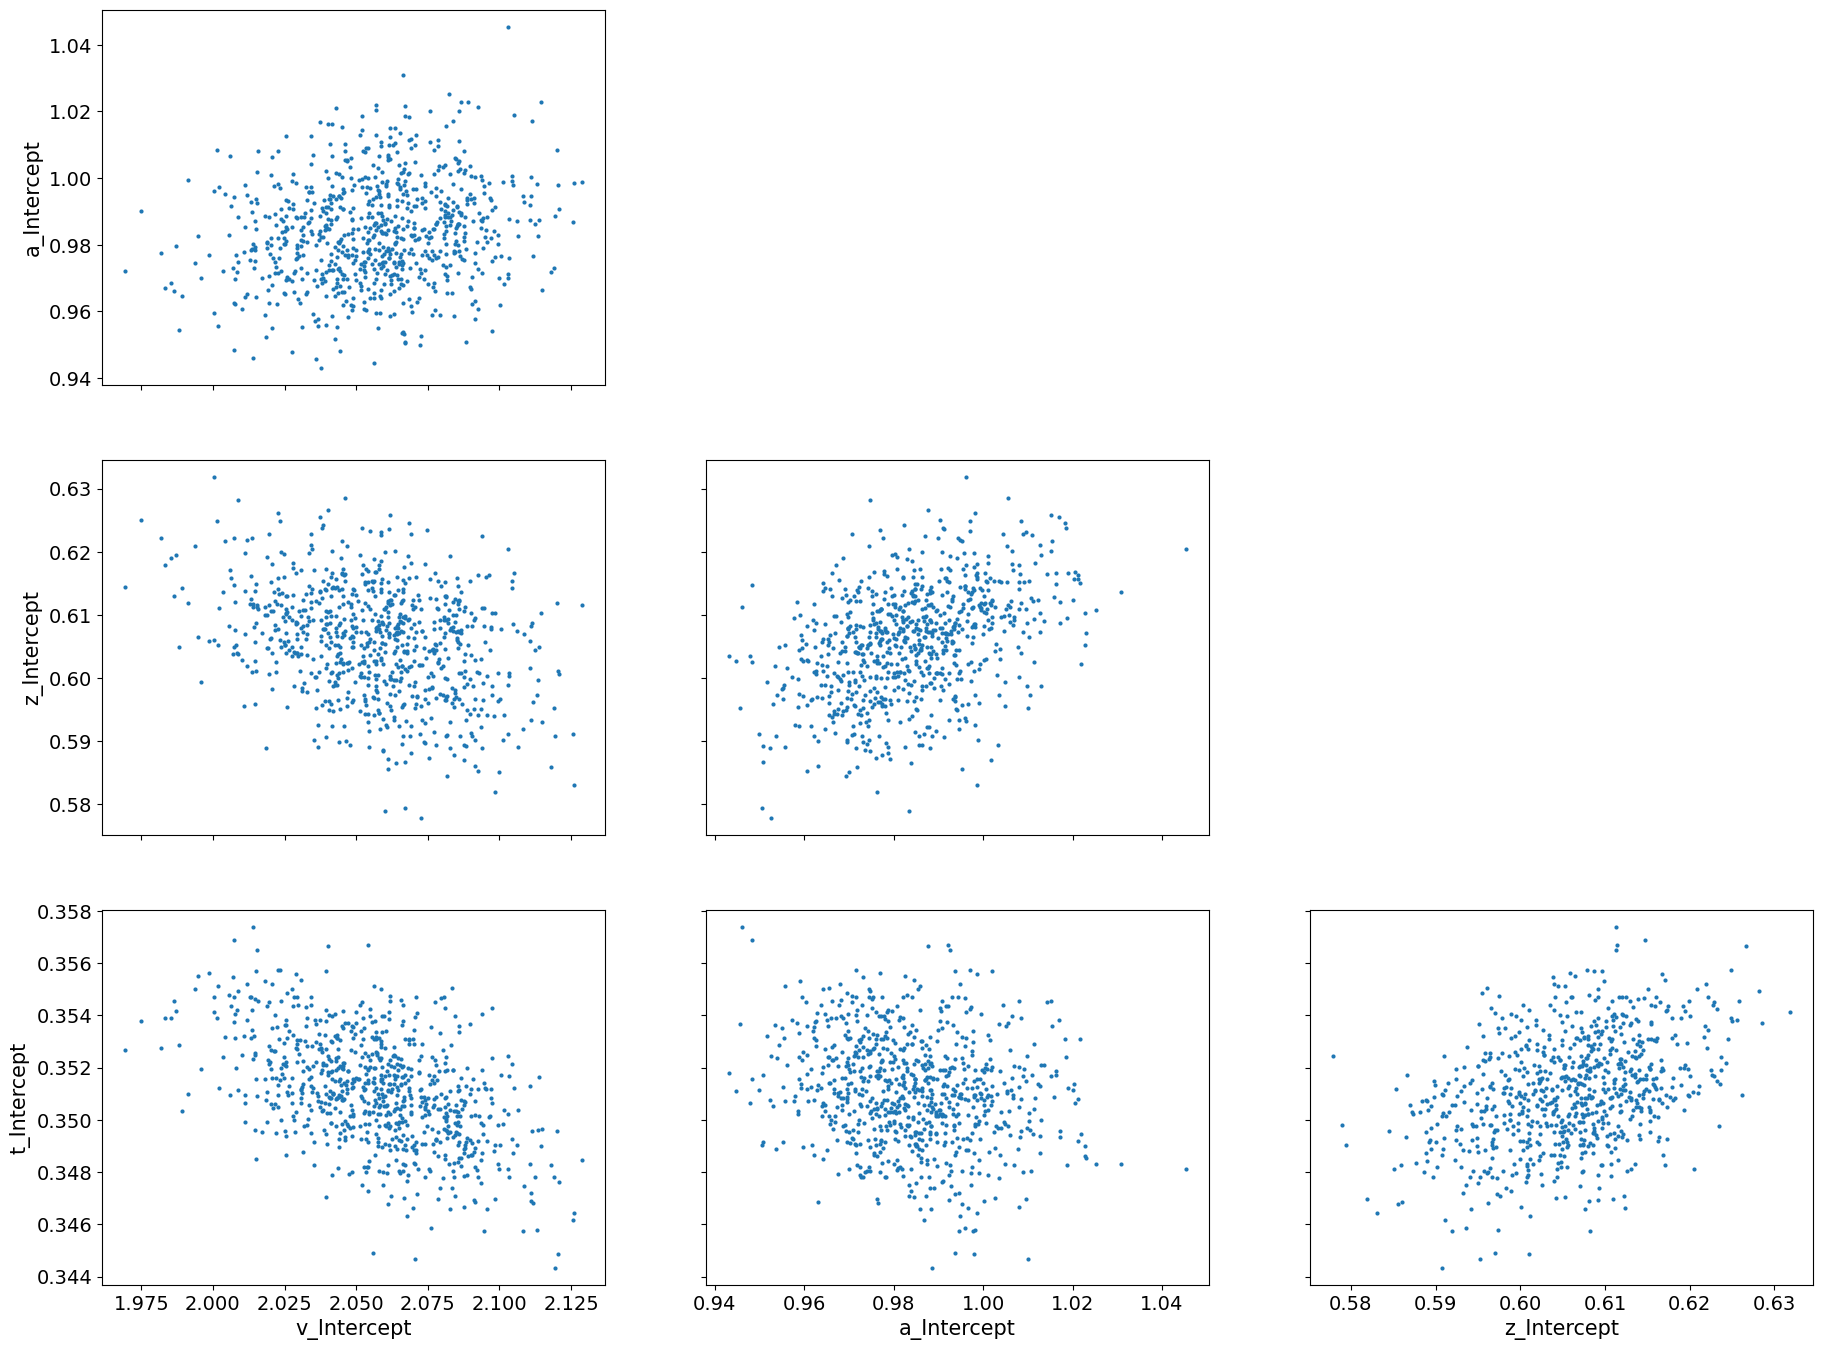

In [78]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

### play around with the ground truth params to simulate data with more errors

In [64]:
vanillaHDDMallFree_simDataEvenChoice=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(dataForModel.loc[dataForModel['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(0.1,0.005), #play with v, closer to zero will lead to more even upper and lower bound choices
                                      np.random.normal(1,0.05), 
                                      np.random.normal(0.6,0.05),
                                      np.random.normal(0.35,0.01)]

    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simDataEvenChoice=pd.concat([vanillaHDDMallFree_simDataEvenChoice, subDataset], ignore_index=True)
    
vanillaHDDMallFree_simDataEvenChoice    

participant_id        rt  response
0             42013.0  2.414007       1.0
1             42013.0  1.059152       1.0
2             42013.0  1.028316      -1.0
3             42013.0  1.948087       1.0
4             42013.0  1.812551      -1.0
...               ...       ...       ...
11079         62433.0  0.598226       1.0
11080         62433.0  1.437814       1.0
11081         62433.0  1.256375      -1.0
11082         62433.0  0.573281       1.0
11083         62433.0  2.346781       1.0

[11084 rows x 3 columns]

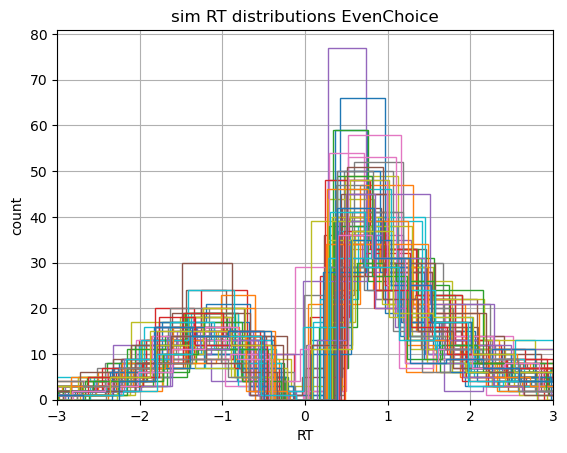

In [66]:
vanillaHDDMallFree_simDataEvenChoice['rtPlot']=vanillaHDDMallFree_simDataEvenChoice['rt']
vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']=vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions EvenChoice')
for i, subj_data in vanillaHDDMallFree_simDataEvenChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-3,3)   
plt.savefig('sim_subRT_dist_even.pdf')

In [72]:
ddm_simple_allFree_hier_even = hssm.HSSM(
    data=vanillaHDDMallFree_simDataEvenChoice,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [73]:
inferenceData_ddm_simple_allFree_hier_even=ddm_simple_allFree_hier_even.sample(
    sampler="nuts_numpyro",
    chains=2,
    draws=400,
    tune=400,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/minico

In [75]:
inferenceData_ddm_simple_allFree_hier_even

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

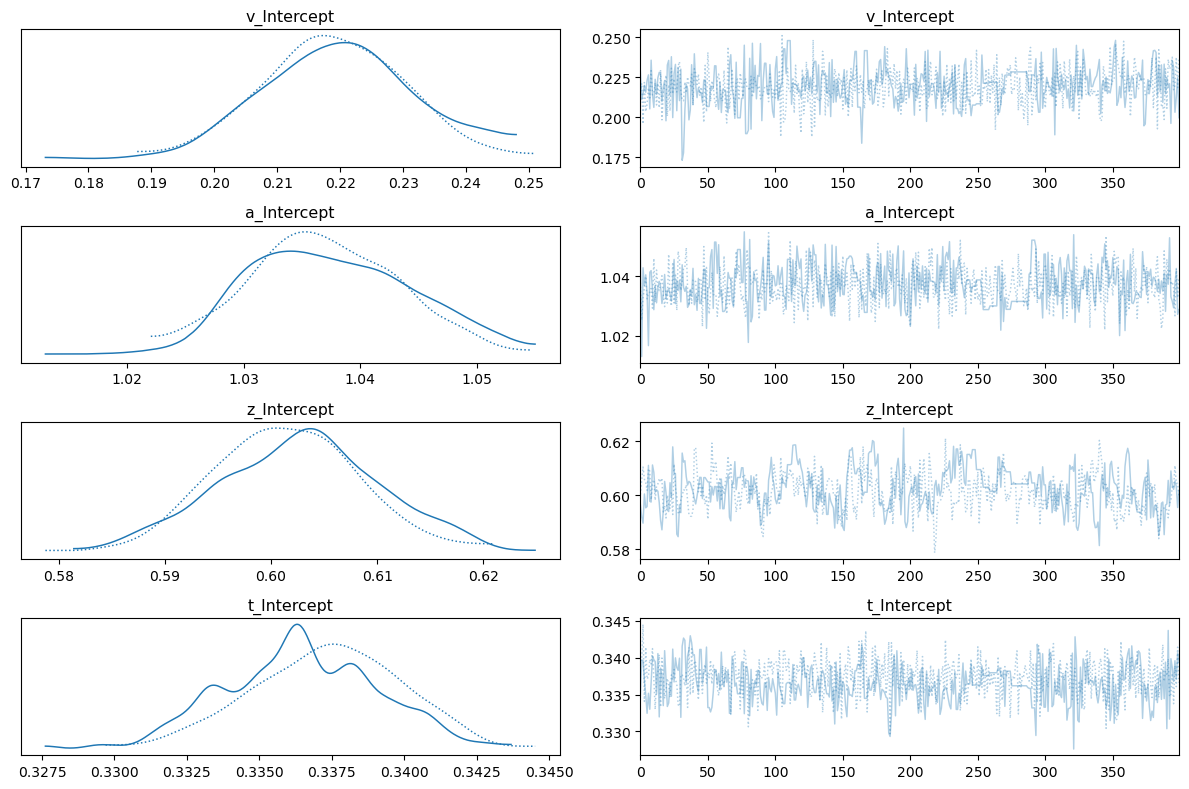

In [76]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier_even,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

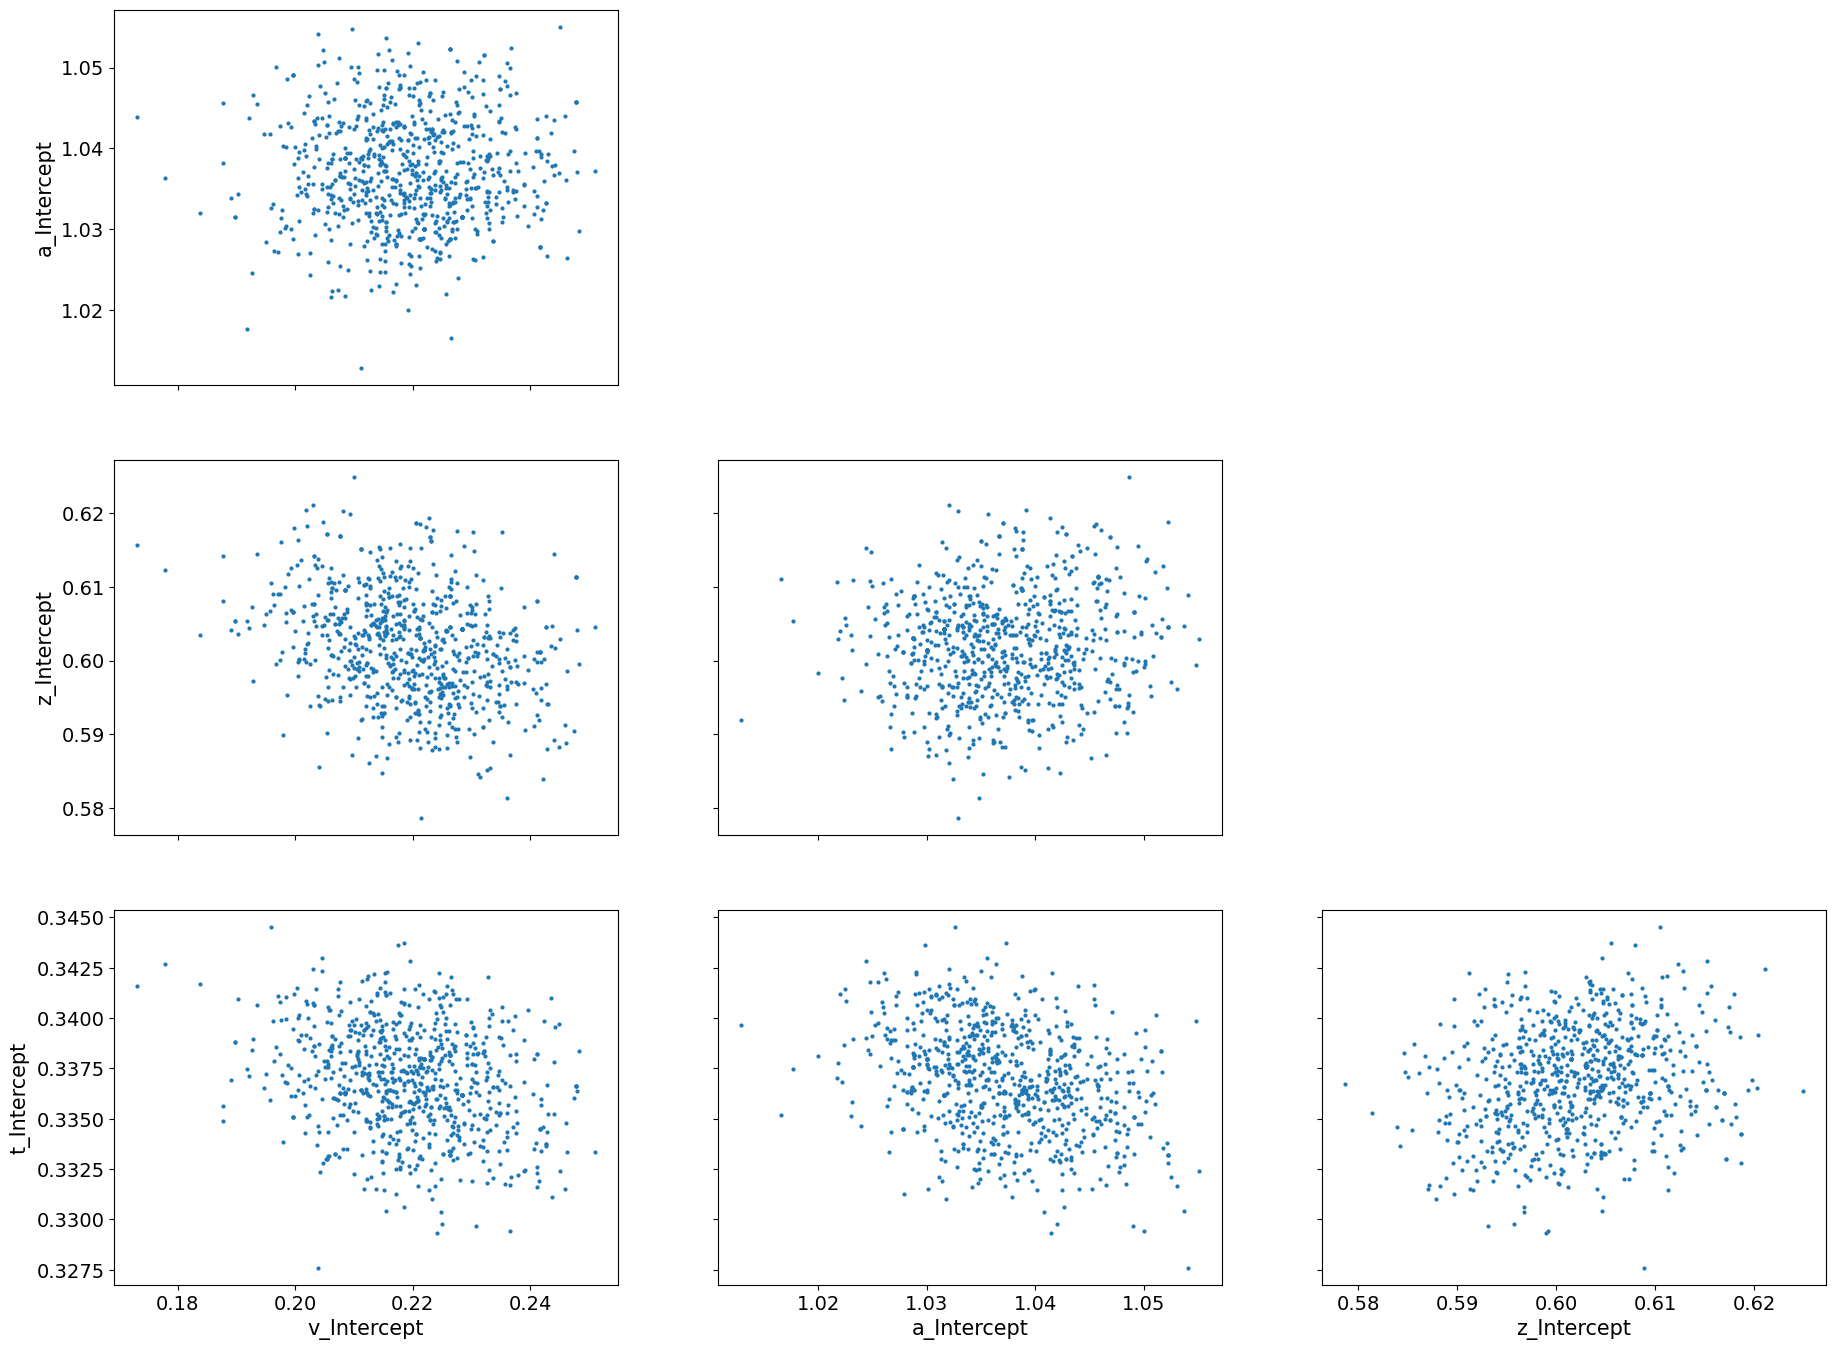

In [79]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier_even,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

## mcmc

In [ ]:
ssms.config.model_config['ddm']

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'boundary_params': [],
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'nchoices': 2,
 'simulator': <cyfunction ddm_flexbound at 0x7f90a0f72260>}

In [92]:
vanillaHDDMallFree_simData=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2.loc[oddballDataDay2['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(2,0.05), 
                                      np.random.normal(1,0.05), 
                                      np.random.normal(0.6,0.05),
                                      np.random.normal(0.35,0.01)]

    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simData=pd.concat([vanillaHDDMallFree_simData, subDataset], ignore_index=True)

In [ ]:
vanillaHDDMallFree_simData

participant_id        rt  response
0             42013.0  0.392496       1.0
1             42013.0  0.439485       1.0
2             42013.0  0.707260       1.0
3             42013.0  0.626655       1.0
4             42013.0  0.573257       1.0
...               ...       ...       ...
11079         62433.0  1.079464       1.0
11080         62433.0  0.844995       1.0
11081         62433.0  0.418700       1.0
11082         62433.0  0.431456       1.0
11083         62433.0  0.945176       1.0

[11084 rows x 3 columns]

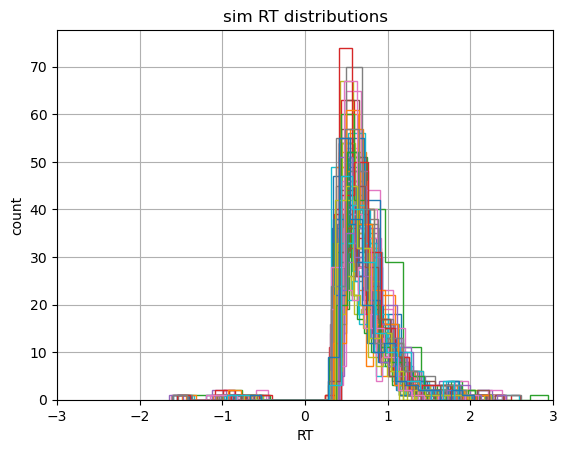

In [93]:
vanillaHDDMallFree_simData['rtPlot']=vanillaHDDMallFree_simData['rt']
vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']=vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions')
for i, subj_data in vanillaHDDMallFree_simData.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-3,3)   
plt.savefig('sim_subRT_dist.pdf')

In [94]:
ddm_simple_allFree_hier = hssm.HSSM(
    data=vanillaHDDMallFree_simData,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [95]:
inferenceData_ddm_simple_allFree_hier=ddm_simple_allFree_hier.sample(
    sampler="mcmc",
    chains=2,
    draws=400,
    tune=400,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_Intercept, v_1|participant_id_sigma, v_1|participant_id, a_Intercept, a_1|participant_id_sigma, a_1|participant_id, z_Intercept, z_1|participant_id_sigma, z_1|participant_id, t_Intercept, t_1|participant_id_sigma, t_1|participant_id]
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

In [2]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

NameError: name 'inferenceData_ddm_simple_allFree_hier' is not defined

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

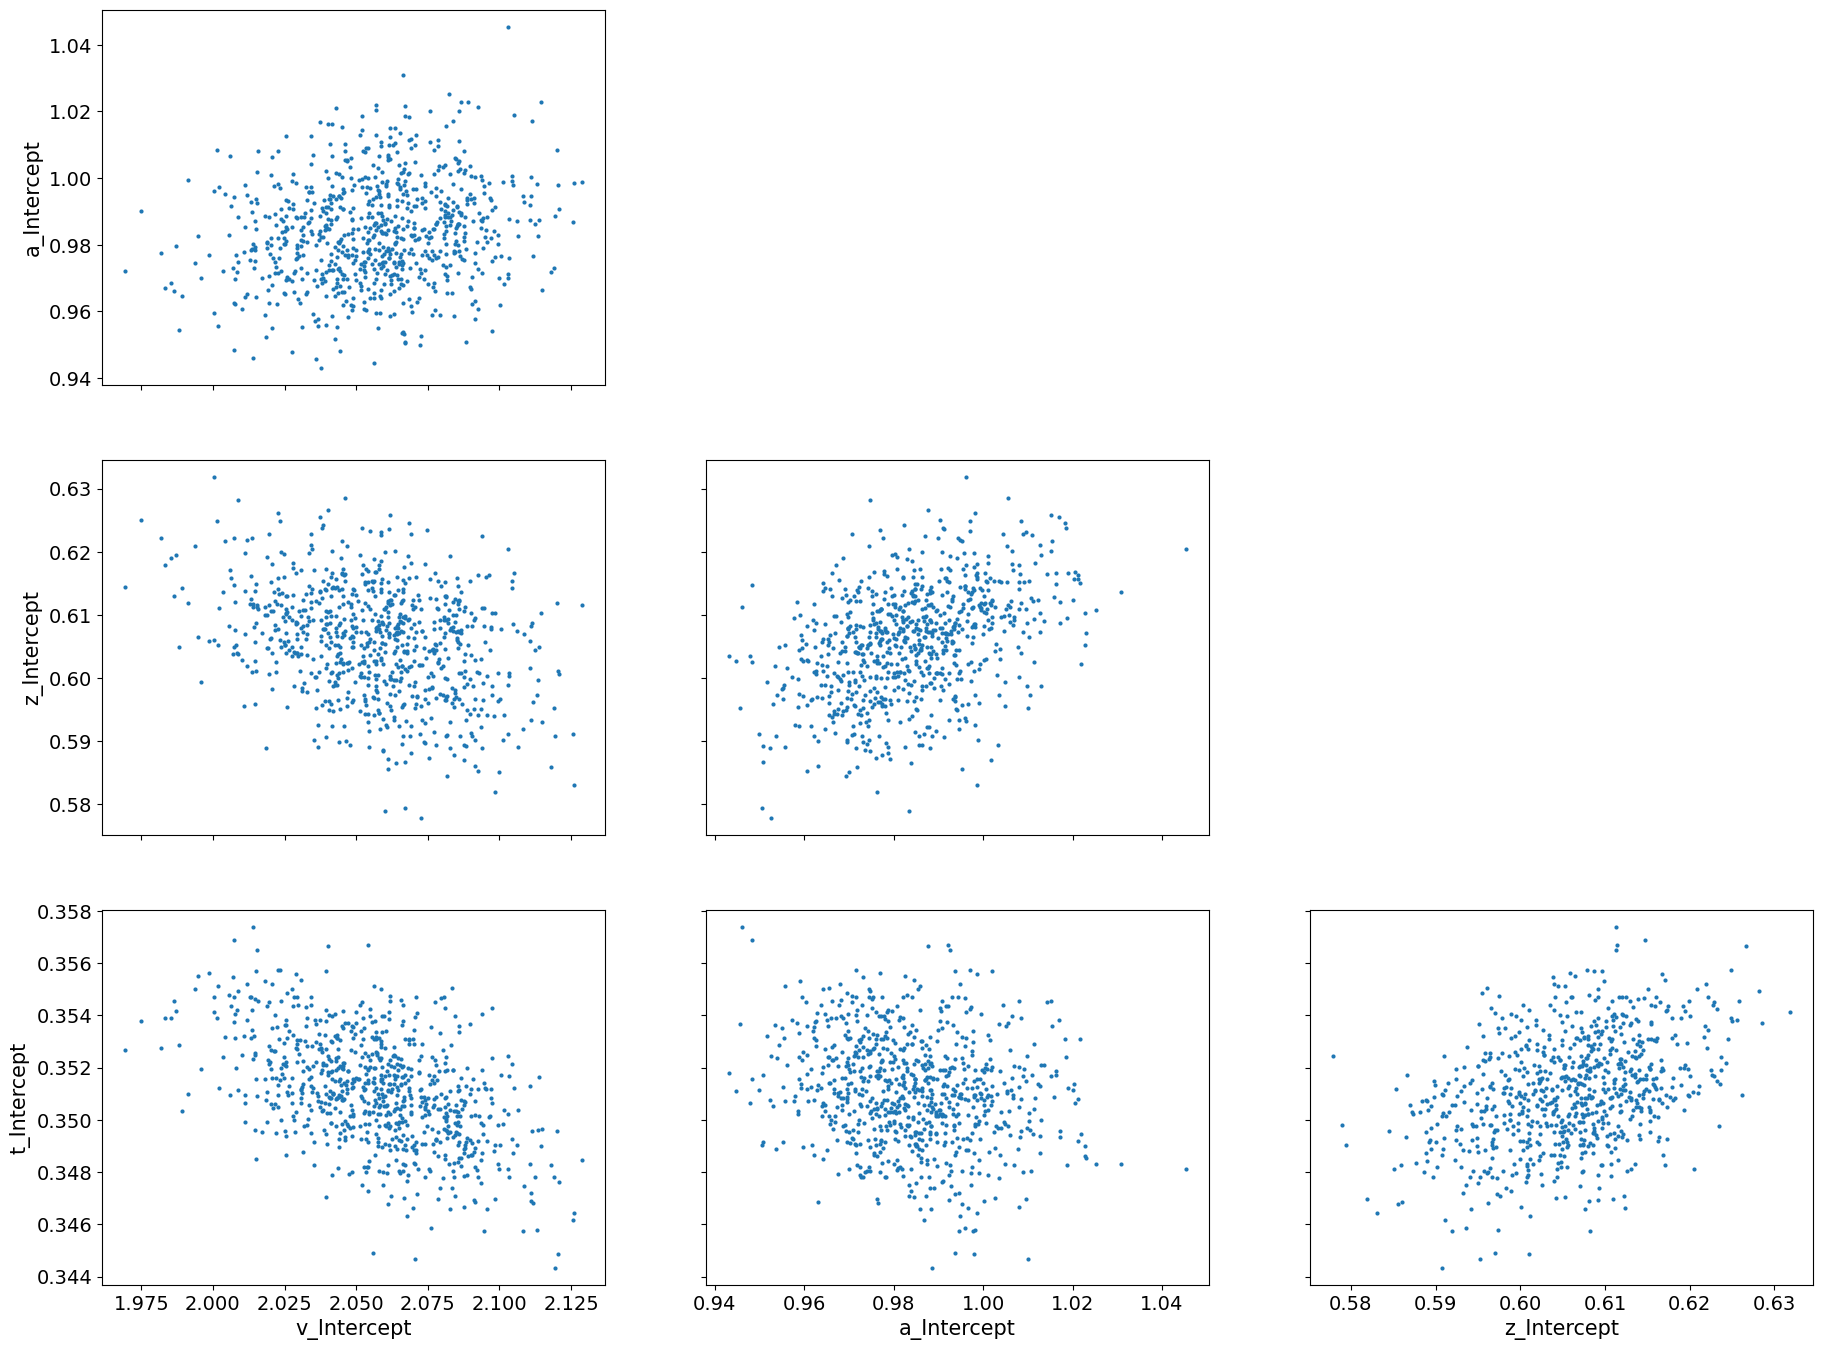

In [ ]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

### play around with the ground truth params to simulate data with more errors

In [ ]:
vanillaHDDMallFree_simDataEvenChoice=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2.loc[oddballDataDay2['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(0.1,0.005), #play with v, closer to zero will lead to more even upper and lower bound choices
                                      np.random.normal(1,0.05), 
                                      np.random.normal(0.6,0.05),
                                      np.random.normal(0.35,0.01)]

    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simDataEvenChoice=pd.concat([vanillaHDDMallFree_simDataEvenChoice, subDataset], ignore_index=True)
    
vanillaHDDMallFree_simDataEvenChoice    

participant_id        rt  response
0             42013.0  2.414007       1.0
1             42013.0  1.059152       1.0
2             42013.0  1.028316      -1.0
3             42013.0  1.948087       1.0
4             42013.0  1.812551      -1.0
...               ...       ...       ...
11079         62433.0  0.598226       1.0
11080         62433.0  1.437814       1.0
11081         62433.0  1.256375      -1.0
11082         62433.0  0.573281       1.0
11083         62433.0  2.346781       1.0

[11084 rows x 3 columns]

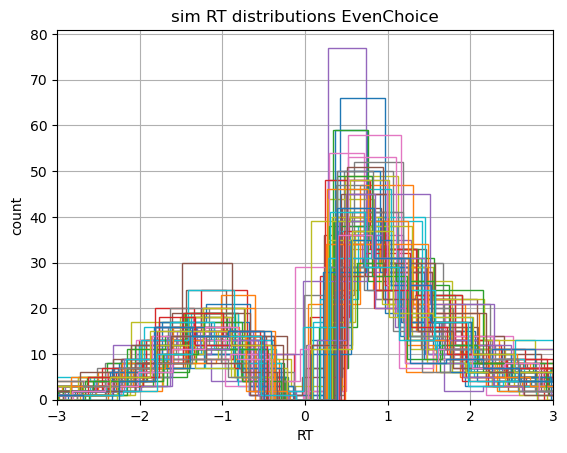

In [ ]:
vanillaHDDMallFree_simDataEvenChoice['rtPlot']=vanillaHDDMallFree_simDataEvenChoice['rt']
vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']=vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions EvenChoice')
for i, subj_data in vanillaHDDMallFree_simDataEvenChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-3,3)   
plt.savefig('sim_subRT_dist_even.pdf')

In [ ]:
ddm_simple_allFree_hier_even = hssm.HSSM(
    data=vanillaHDDMallFree_simDataEvenChoice,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [ ]:
inferenceData_ddm_simple_allFree_hier_even=ddm_simple_allFree_hier_even.sample(
    sampler="mcmc",
    chains=2,
    draws=400,
    tune=400,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/minico

In [ ]:
inferenceData_ddm_simple_allFree_hier_even

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

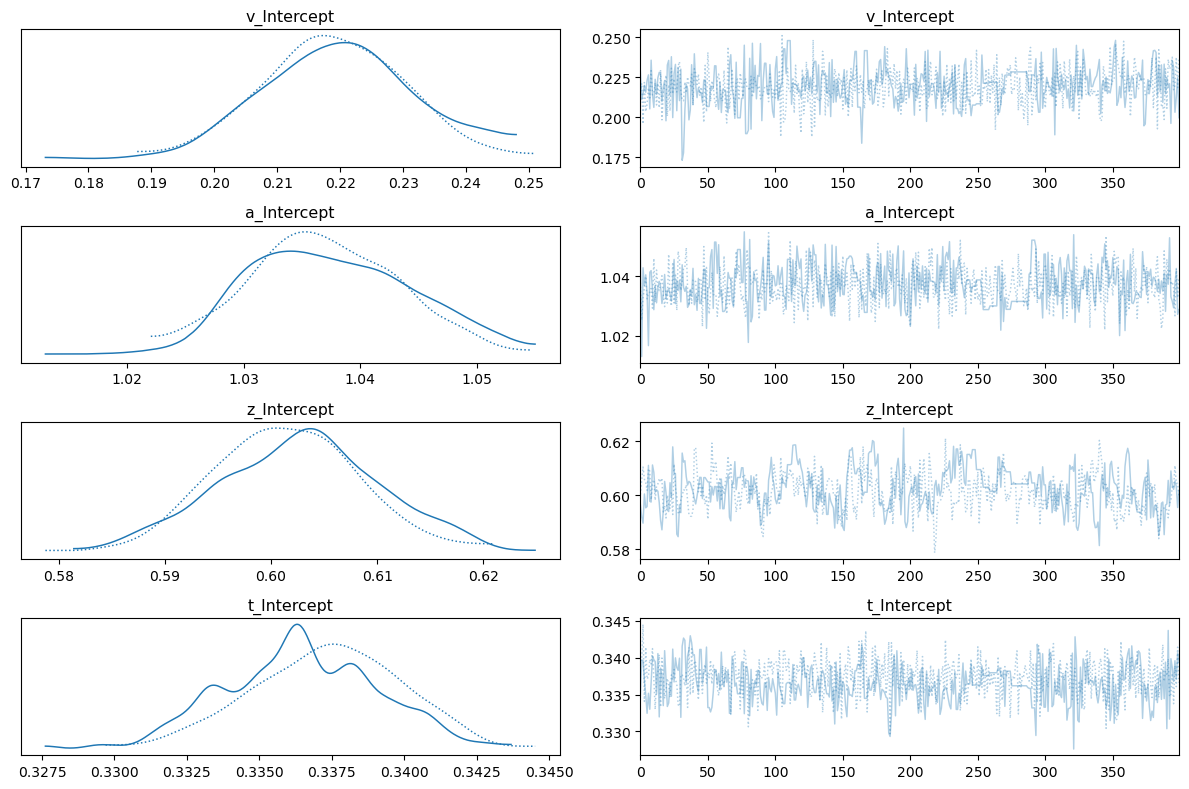

In [ ]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier_even,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

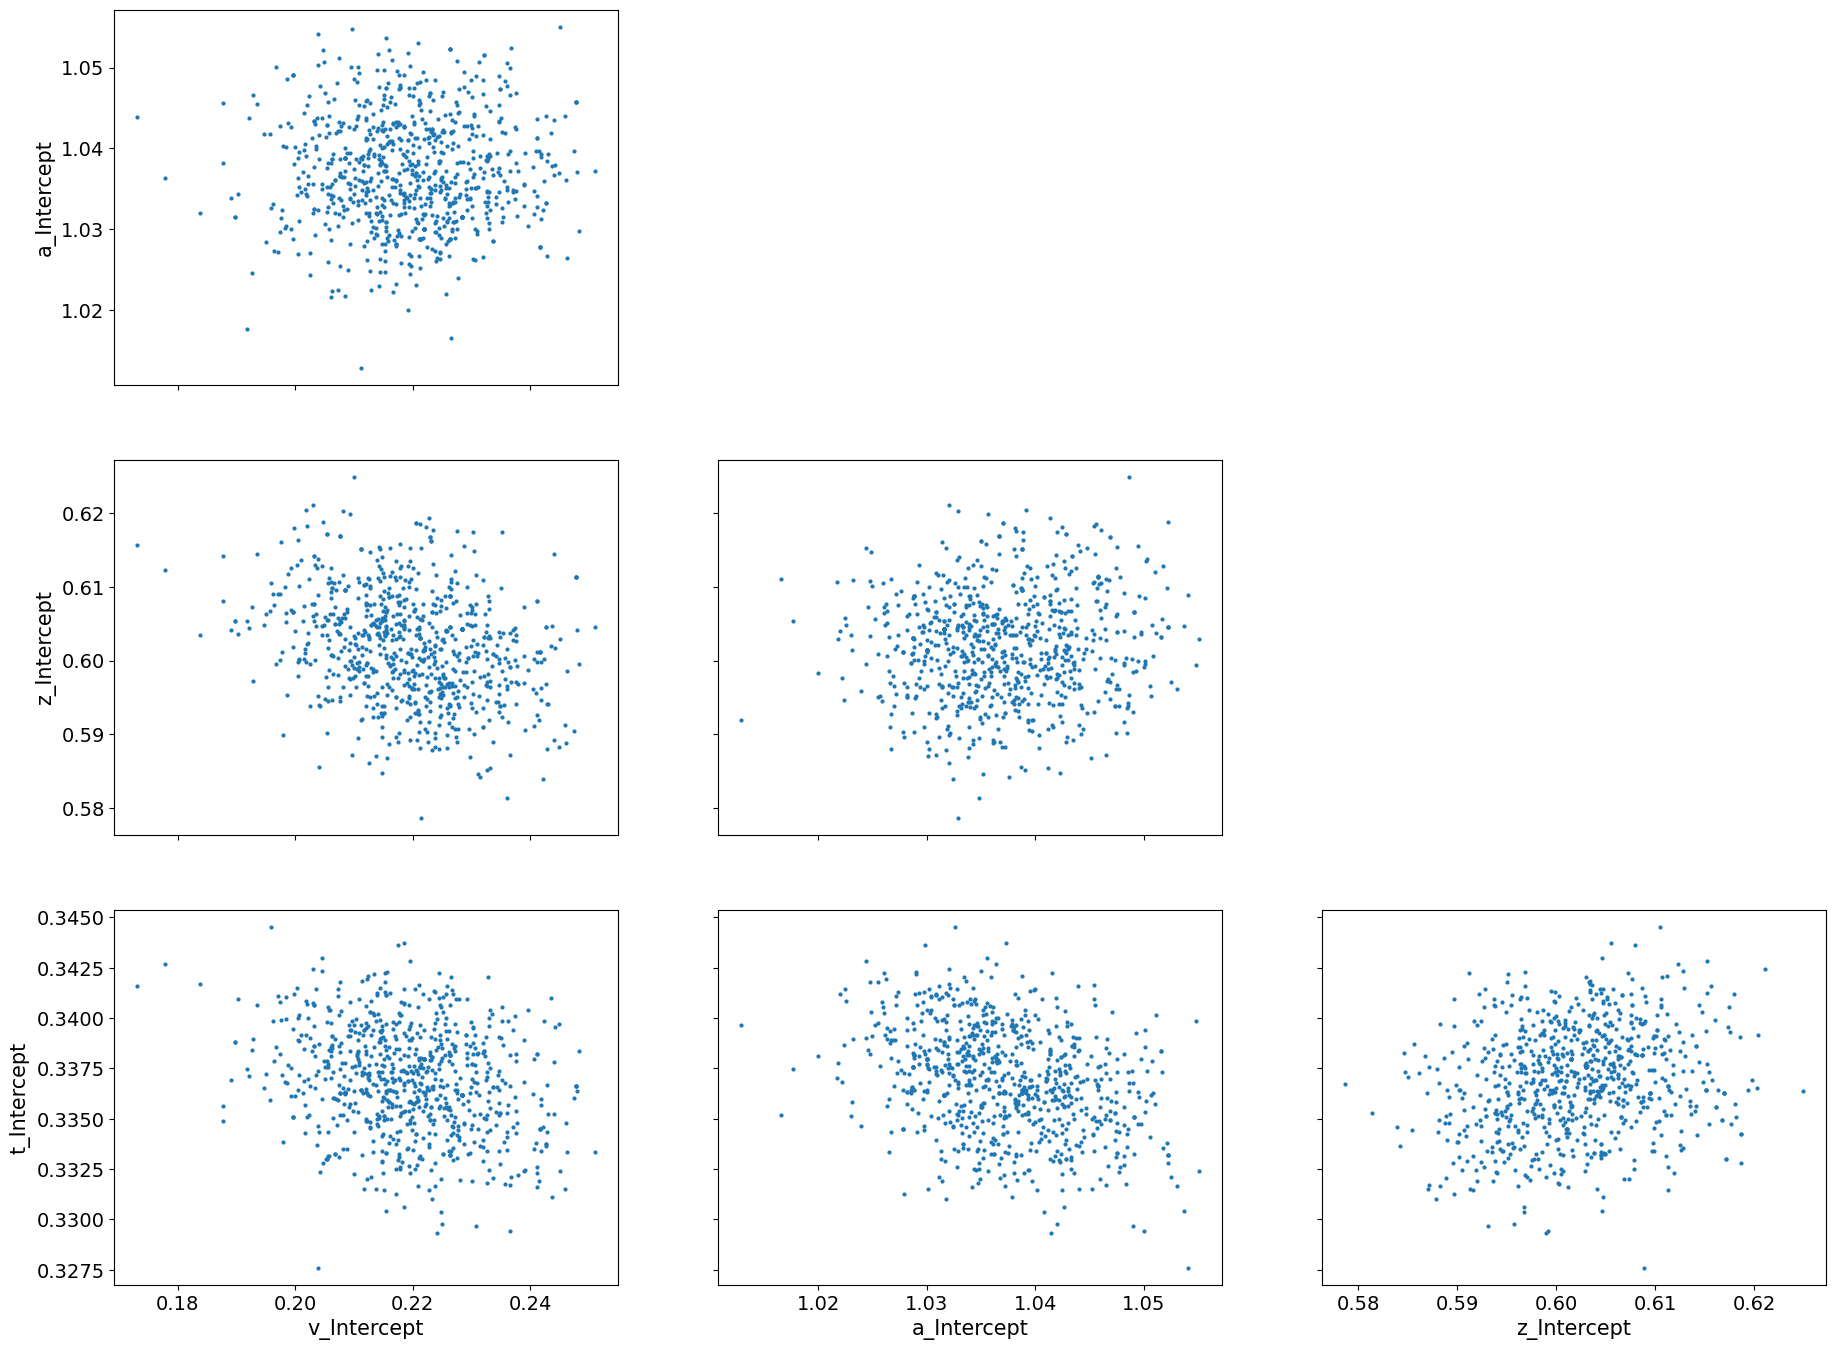

In [ ]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier_even,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

## nuts numpyro with ground truth from real data instead 

In [ ]:
ssms.config.model_config['ddm']

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'boundary_params': [],
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'nchoices': 2,
 'simulator': <cyfunction ddm_flexbound at 0x7f90a0f72260>}

In [11]:
vanillaHDDMallFree_simData=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2.loc[oddballDataDay2['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(2.021,0.005), 
                                      np.random.normal(1.405,0.068), 
                                      np.random.normal(0.573,0.056),
                                      np.random.normal(0.372,0.029)]


    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simData=pd.concat([vanillaHDDMallFree_simData, subDataset], ignore_index=True)

In [ ]:
vanillaHDDMallFree_simData

participant_id        rt  response
0             42013.0  0.392496       1.0
1             42013.0  0.439485       1.0
2             42013.0  0.707260       1.0
3             42013.0  0.626655       1.0
4             42013.0  0.573257       1.0
...               ...       ...       ...
11079         62433.0  1.079464       1.0
11080         62433.0  0.844995       1.0
11081         62433.0  0.418700       1.0
11082         62433.0  0.431456       1.0
11083         62433.0  0.945176       1.0

[11084 rows x 3 columns]

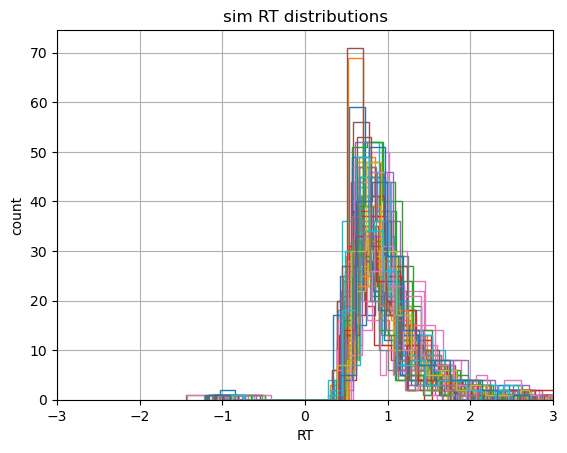

In [12]:
vanillaHDDMallFree_simData['rtPlot']=vanillaHDDMallFree_simData['rt']
vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']=vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions')
for i, subj_data in vanillaHDDMallFree_simData.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-3,3)   
plt.savefig('sim_subRT_dist.pdf')

In [13]:
ddm_simple_allFree_hier = hssm.HSSM(
    data=vanillaHDDMallFree_simData,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [14]:
inferenceData_ddm_simple_allFree_hier=ddm_simple_allFree_hier.sample(
    sampler="nuts_numpyro",
    chains=2,
    draws=400,
    tune=400,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



2024-09-01 13:37:24.184741: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods

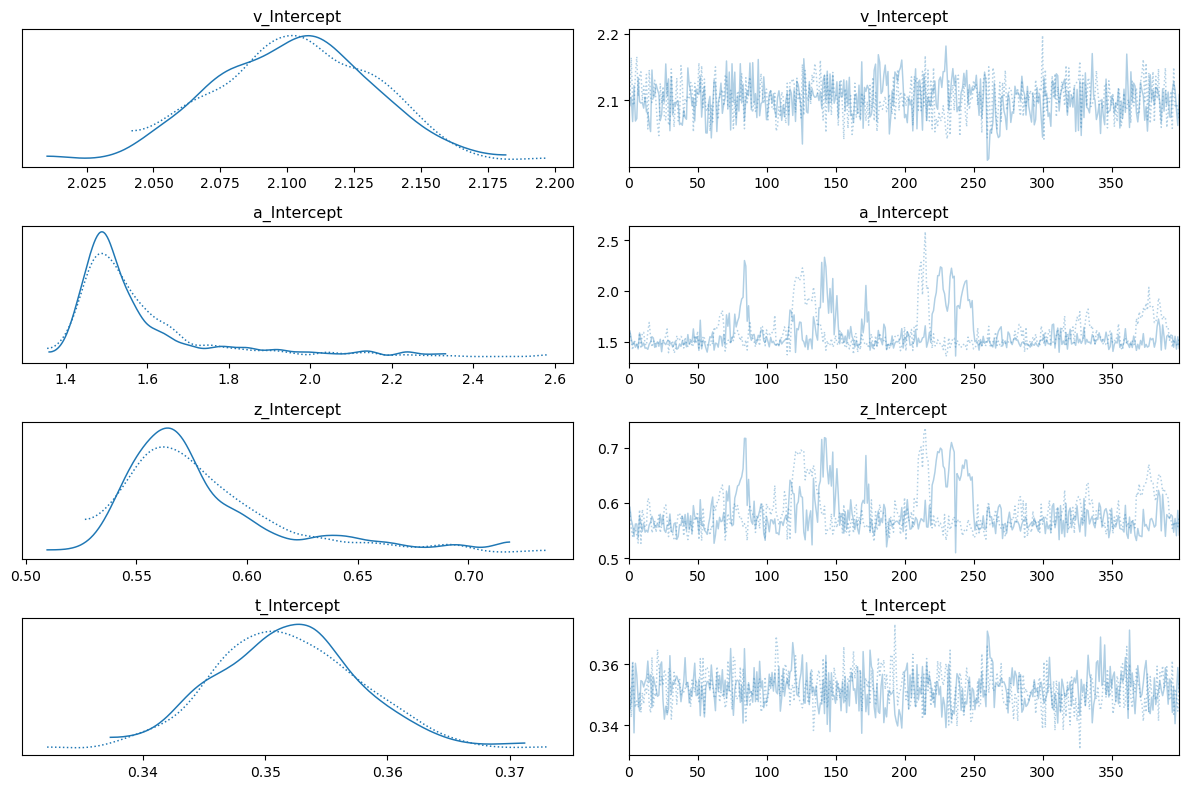

In [15]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

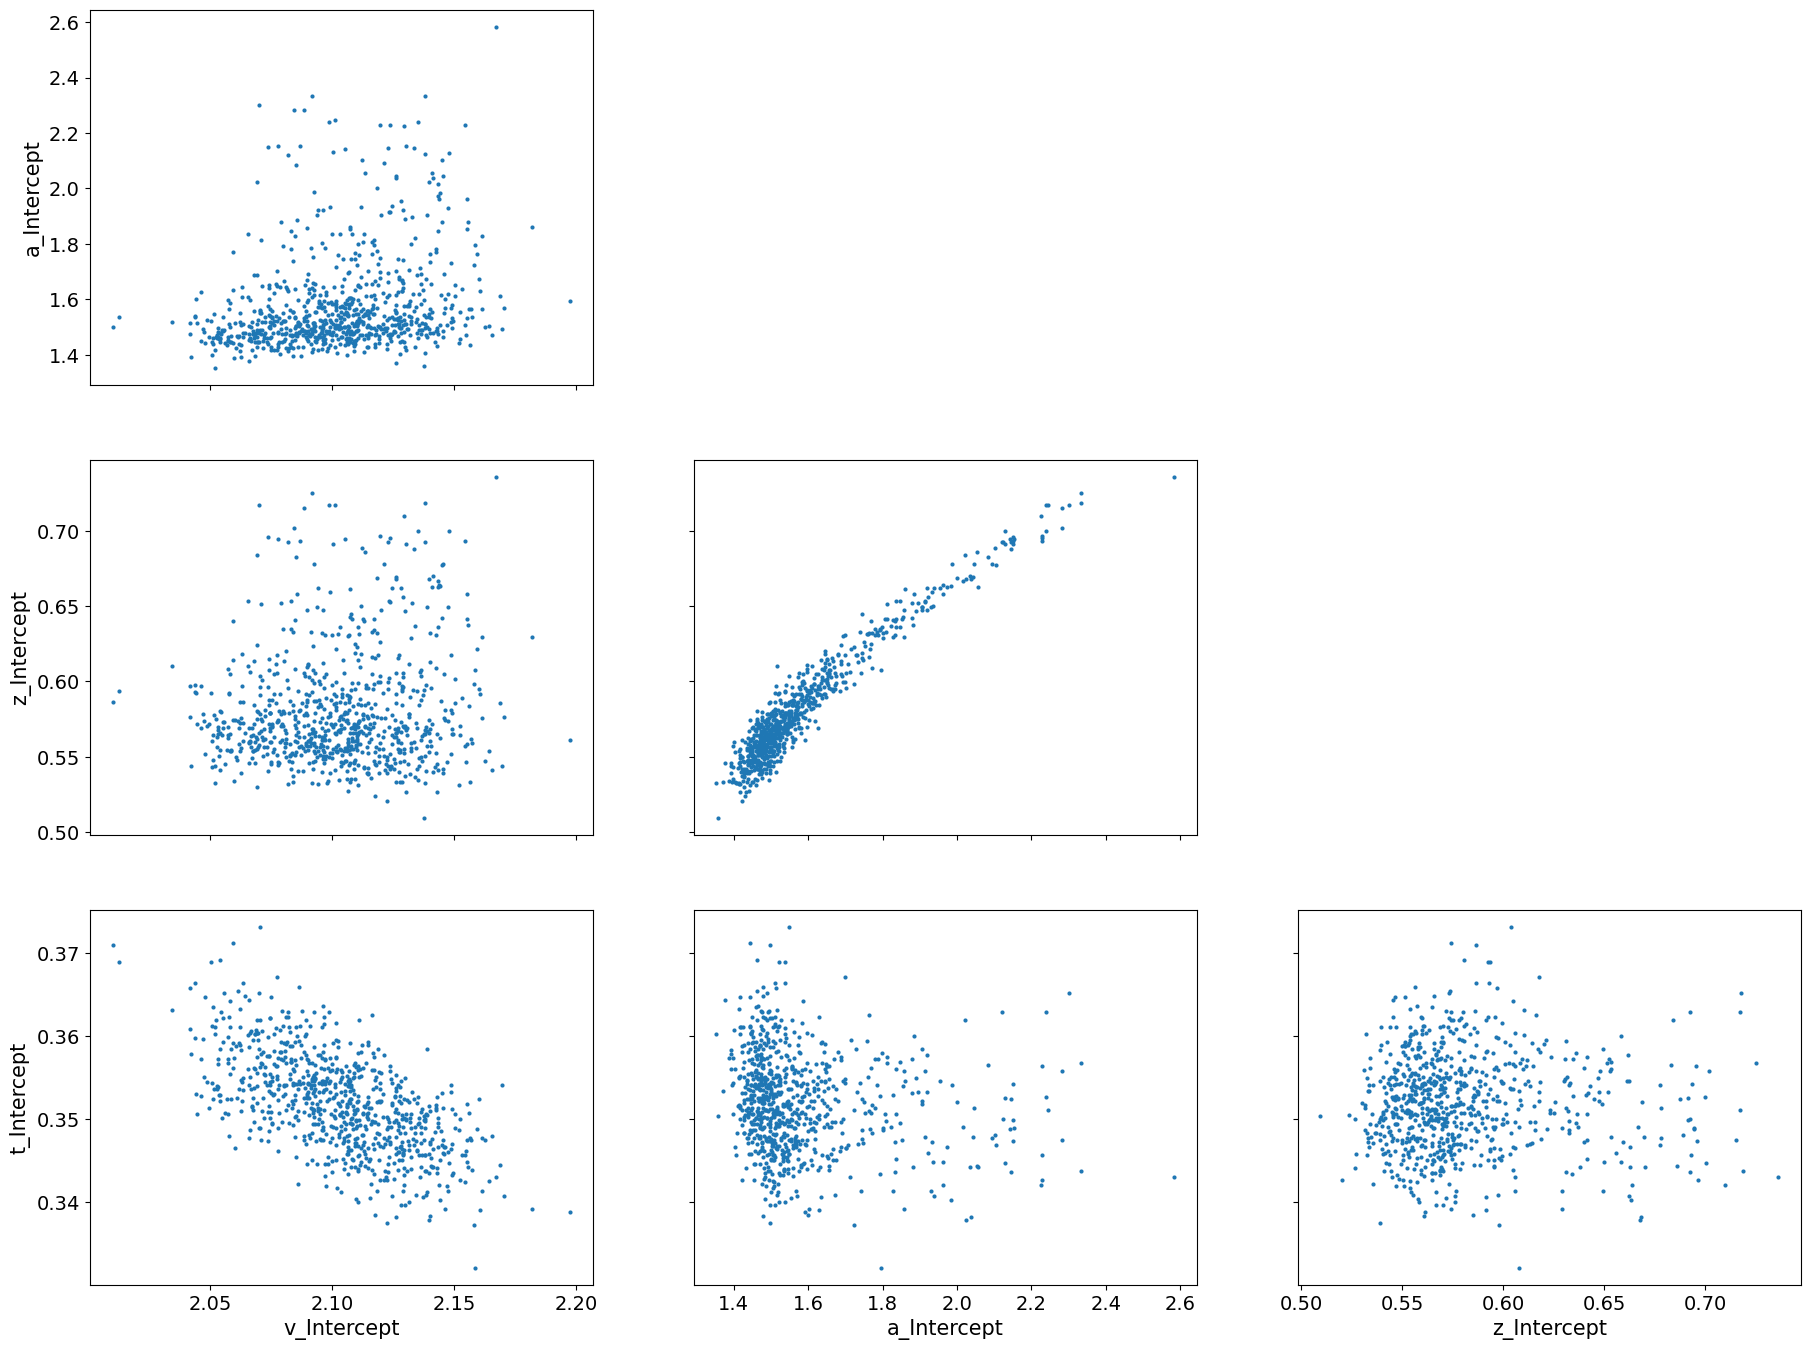

In [16]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

### play around with the ground truth params to simulate data with more errors

In [ ]:
vanillaHDDMallFree_simDataEvenChoice=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(dataForModel.loc[dataForModel['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(0.1,0.005), #play with v, closer to zero will lead to more even upper and lower bound choices
                                      np.random.normal(1,0.05), 
                                      np.random.normal(0.6,0.05),
                                      np.random.normal(0.35,0.01)]

    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simDataEvenChoice=pd.concat([vanillaHDDMallFree_simDataEvenChoice, subDataset], ignore_index=True)
    
vanillaHDDMallFree_simDataEvenChoice    

participant_id        rt  response
0             42013.0  2.414007       1.0
1             42013.0  1.059152       1.0
2             42013.0  1.028316      -1.0
3             42013.0  1.948087       1.0
4             42013.0  1.812551      -1.0
...               ...       ...       ...
11079         62433.0  0.598226       1.0
11080         62433.0  1.437814       1.0
11081         62433.0  1.256375      -1.0
11082         62433.0  0.573281       1.0
11083         62433.0  2.346781       1.0

[11084 rows x 3 columns]

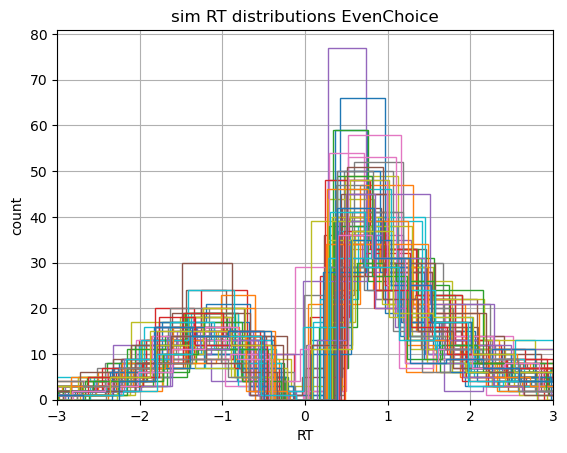

In [ ]:
vanillaHDDMallFree_simDataEvenChoice['rtPlot']=vanillaHDDMallFree_simDataEvenChoice['rt']
vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']=vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions EvenChoice')
for i, subj_data in vanillaHDDMallFree_simDataEvenChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-3,3)   
plt.savefig('sim_subRT_dist_even.pdf')

In [ ]:
ddm_simple_allFree_hier_even = hssm.HSSM(
    data=vanillaHDDMallFree_simDataEvenChoice,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [ ]:
inferenceData_ddm_simple_allFree_hier_even=ddm_simple_allFree_hier_even.sample(
    sampler="nuts_numpyro",
    chains=2,
    draws=400,
    tune=400,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/minico

In [ ]:
inferenceData_ddm_simple_allFree_hier_even

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

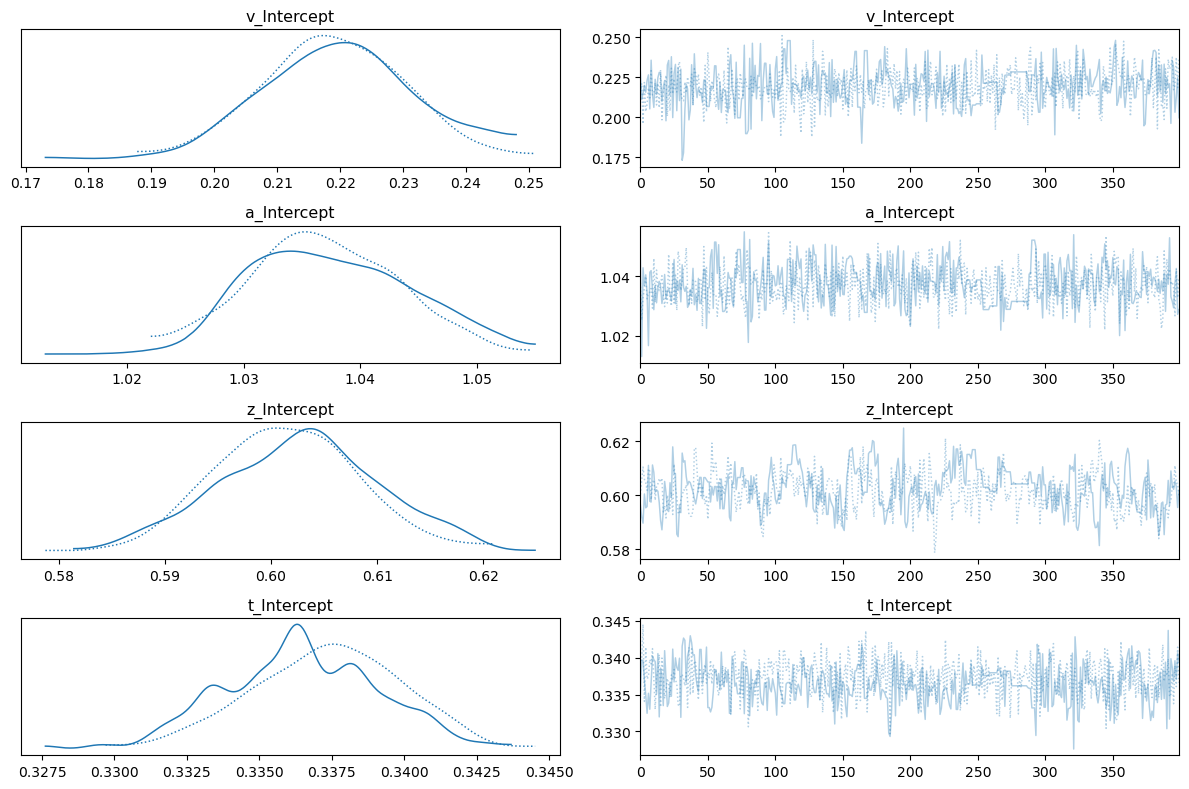

In [ ]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier_even,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

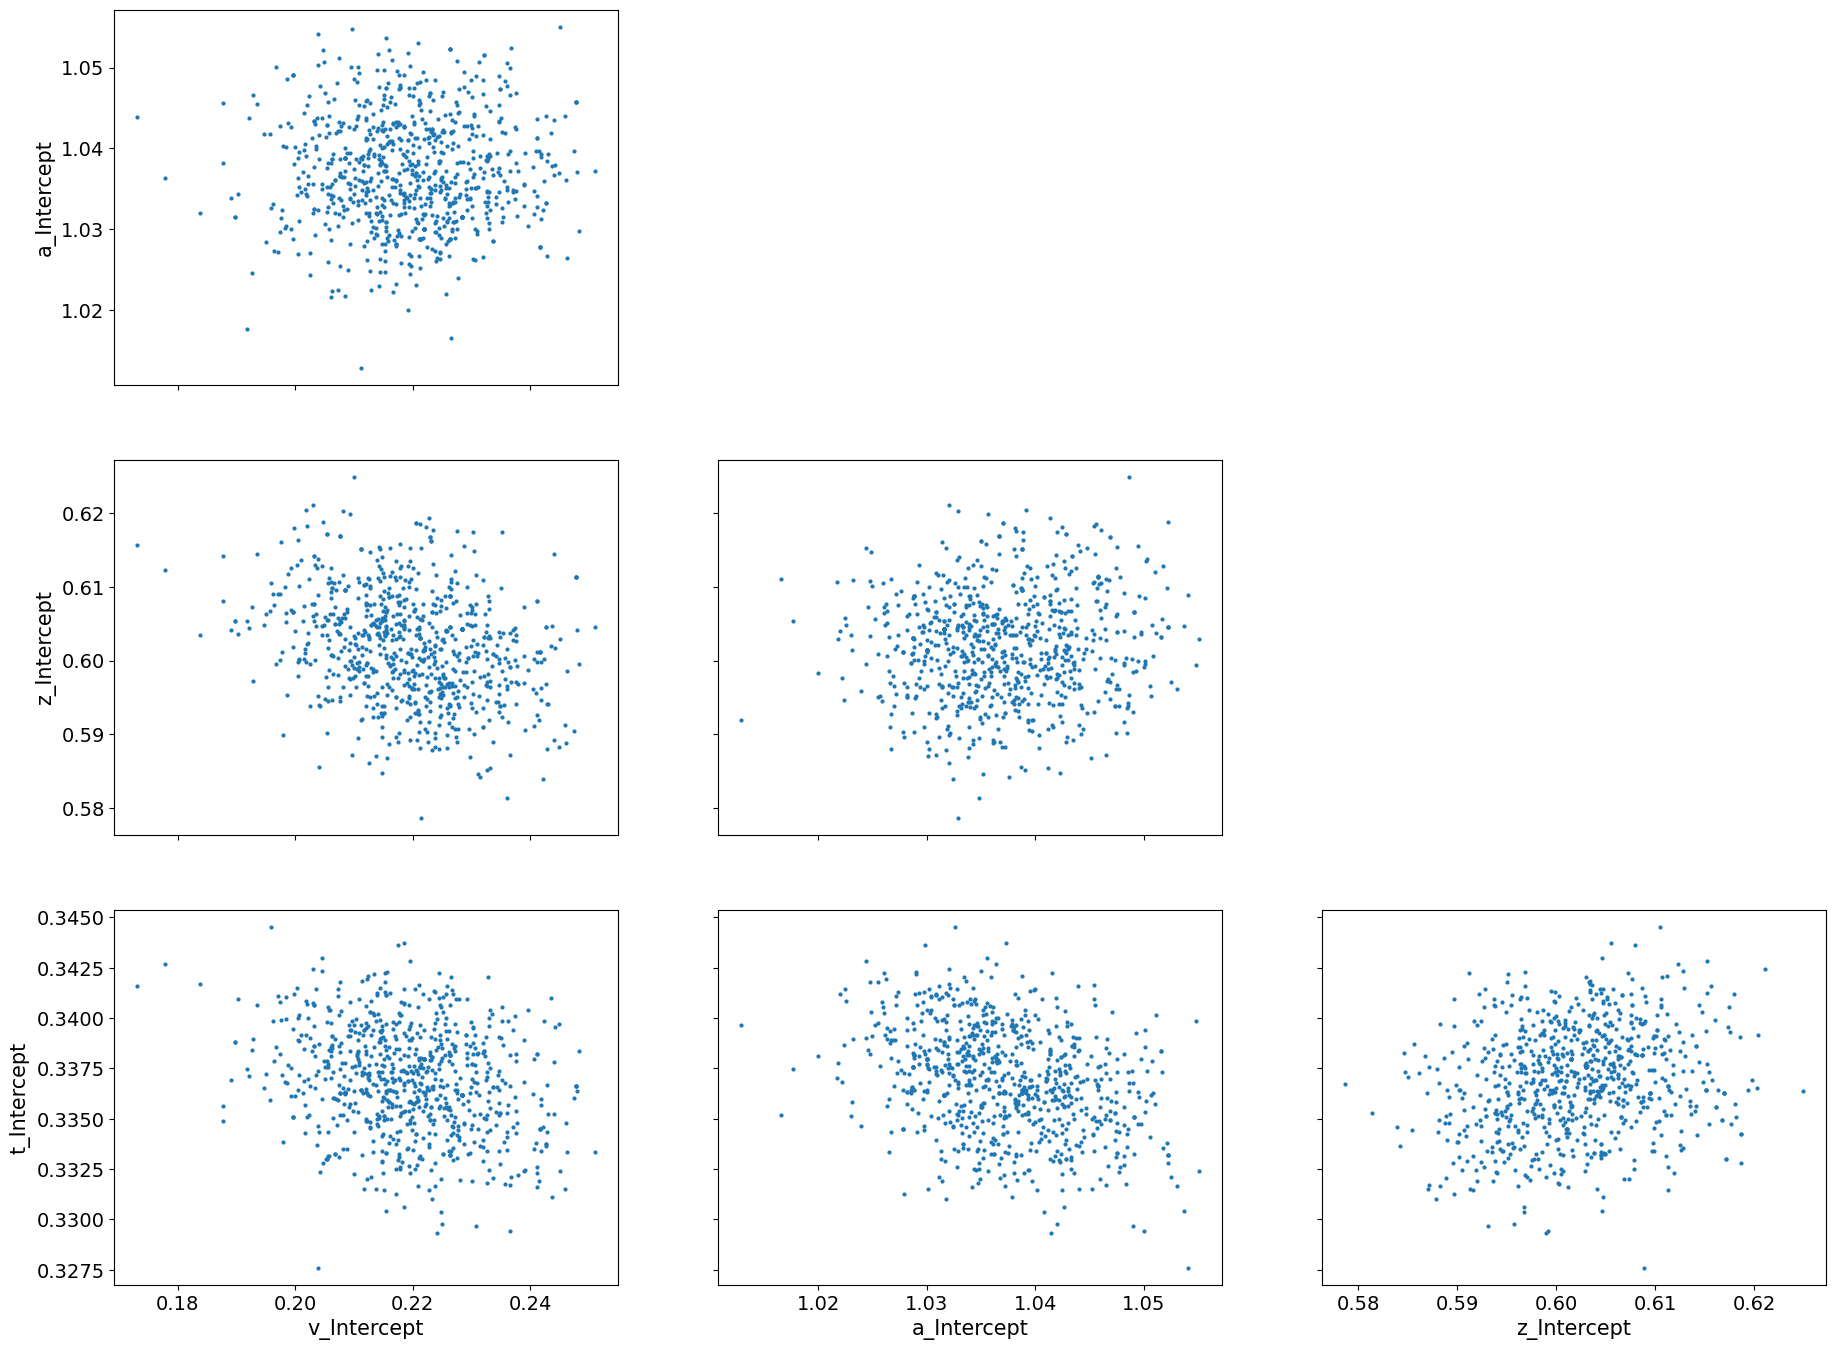

In [ ]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier_even,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])